# Import

In [1]:
from tqdm.notebook import tqdm
from metrics.distributional import  compute_fid
from metrics.image import compute_image_distance_repeated
from metrics.perceptual import load_perceptual_models, compute_perceptual_metric_repeated
from metrics.aesthetics import load_aesthetics_and_artifacts_models, compute_aesthetics_and_artifacts_scores
from metrics.clip import load_open_clip_model_preprocess_and_tokenizer, compute_clip_score

/home/yehias21/anaconda3/envs/metrics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import random,glob, os
from glob import glob
import pickle
from PIL import Image
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
# from clip_interrogator import Config, Interrogator

# Import image paths

In [5]:
beige_watermarked_images = "/media/yehias21/DATA/projects/Masters/workshops/Neurips24_earsingtheinvisible/watermark_analysis/data/Neurips24_ETI_BeigeBox"
black_watermarked_images = "/media/yehias21/DATA/projects/Masters/workshops/Neurips24_earsingtheinvisible/watermark_analysis/dataNeurips24_ETI_BlackBox"
path_attacked_images = "/media/yehias21/DATA/projects/Masters/workshops/Neurips24_earsingtheinvisible/watermark_analysis/data/thisishowitend"
bg_wm_paths = glob(f"{beige_watermarked_images}/**/*.png", recursive=True)
blk_wm_paths = glob(f"{black_watermarked_images}/**/*.png", recursive=True)
att_paths = glob(f"{path_attacked_images}/**/*.png", recursive=True)
# sort them depends on image number
bg_wm_paths.sort(key=lambda x: int(x.split("/")[-1].split(".")[0]))
att_paths.sort(key=lambda x: int(x.split("/")[-1].split(".")[0]))
blk_wm_paths.sort(key=lambda x: int(x.split("/")[-1].split(".")[0]))

# Prompt creating

In [3]:
caption_model_name = 'git-large-coco' #@param ["blip-base", "blip-large", "git-large-coco"]
clip_model_name = 'ViT-H-14/laion2b_s32b_b79k' #@param ["ViT-L-14/openai", "ViT-H-14/laion2b_s32b_b79k"]

config = Config()
config.clip_model_name = clip_model_name
config.caption_model_name = caption_model_name
ci = Interrogator(config)

def image_to_prompt(image, mode):
    ci.config.chunk_size = 8192 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    ci.config.flavor_intermediate_count = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    image = image.convert('RGB')
    if mode == 'best':
        return ci.interrogate(image)
    elif mode == 'classic':
        return ci.interrogate_classic(image)
    elif mode == 'fast':
        return ci.interrogate_fast(image)
    elif mode == 'negative':
        return ci.interrogate_negative(image)

Loading caption model git-large-coco...


/home/nils.lukas/anaconda3/envs/ada-waves/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading CLIP model ViT-H-14/laion2b_s32b_b79k...


/home/nils.lukas/anaconda3/envs/ada-waves/lib/python3.10/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkp

Loaded CLIP model and data in 18.33 seconds.


In [ ]:
blk_prompts = {}
for img_path in tqdm(blk_wm_paths):
    img, image_name = Image.open(img_path), os.path.basename(img_path)
    prompt = image_to_prompt(img, mode='best')
    blk_prompts[image_name] = prompt
beige_prompts = {}
for img_path in tqdm(bg_wm_paths):
    img, image_name = Image.open(img_path), os.path.basename(img_path)
    prompt = image_to_prompt(img, mode='best')
    beige_prompts[image_name] = prompt
import pickle
with open('blk_prompts.pkl', 'wb') as f:
    pickle.dump(blk_prompts, f)
with open('beige_prompts.pkl', 'wb') as f:
    pickle.dump(beige_prompts, f)

# Image metrics

### image show

The index is:  267


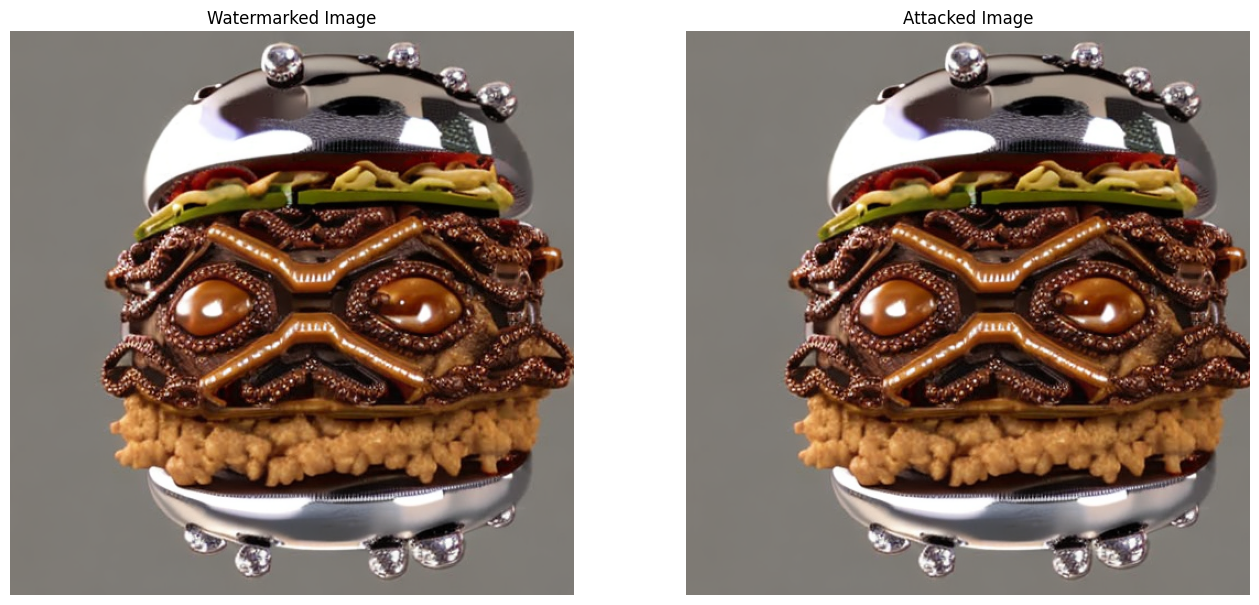

In [6]:
random.seed(17)
idx = random.randint(0, len(bg_wm_paths))
print("The index is: ", idx)
# open the two images 
wm_images, att_images = [Image.open(bg_wm_paths[idx])], [Image.open(att_paths[idx])] 
# show the two image side by side
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
ax[0].imshow(wm_images[0])
ax[0].set_title("Watermarked Image")
ax[0].axis("off")
ax[1].imshow(att_images[0])
ax[1].set_title("Attacked Image")
ax[1].axis("off")
plt.show()

### Open Images

In [8]:
# load the prompts
wm_images, att_images = [Image.open(bg_wm_paths[idx]) for idx in range(len(bg_wm_paths))], [Image.open(att_paths[idx]) for idx in range(len(bg_wm_paths))]
with open('/media/yehias21/DATA/projects/Masters/workshops/Neurips24_earsingtheinvisible/watermark_analysis/data/beige_prompts.pkl', 'rb') as f:
    bg_prompts = pickle.load(f)
prompts = [bg_prompts[os.path.basename(bg_wm_paths[idx])] for idx in range(len(bg_wm_paths))]
results = {}

## Pixelwise similarities: SSMI, PSNR, NMI

In [9]:
Image_similarities = ["ssim","psnr","nmi"]
for metric in Image_similarities:
    results[metric] = compute_image_distance_repeated(wm_images, att_images, metric)

## Distribution distances: FID, CLIPFID

In [10]:
model =load_open_clip_model_preprocess_and_tokenizer(
            device=torch.device(f"cuda"))

OutOfMemoryError: CUDA out of memory. Tried to allocate 34.00 MiB. GPU 0 has a total capacity of 3.95 GiB of which 10.94 MiB is free. Process 2447 has 32.98 MiB memory in use. Including non-PyTorch memory, this process has 3.90 GiB memory in use. Of the allocated memory 3.71 GiB is allocated by PyTorch, and 154.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### FID

In [60]:
results['fid'] = compute_fid(wm_images, att_images)

### CLIP score

In [61]:
results['clip'] = compute_clip_score(wm_images, prompts, model)

## Perceptual metrics: LPIPS


In [62]:
lpips = []
for batch in range(0, len(wm_images), 50):
    lpips.extend(compute_perceptual_metric_repeated(wm_images[batch:batch+50], att_images[batch:batch+50], "lpips", mode='vgg',model=None,device="cuda"))
results['lpips'] = lpips

## Aesthetics and artifacts

In [63]:
model = load_aesthetics_and_artifacts_models(device=torch.device(f"cuda"))

In [64]:
aesthetics, artifacts = compute_aesthetics_and_artifacts_scores(
            wm_images, model, device=torch.device(f"cuda")
        )
results['aesthetics'] = aesthetics
results['artifacts'] = artifacts

## Quality aggregator

In [65]:
Q = (
    +1.53 * 10**-3 * results['fid']
    + 5.07 * 10**-3 * np.mean(results['clip'])
    - 2.22 * 10**-3 * np.mean(results['psnr'])
    - 1.13 * 10**-1 * np.mean(results['ssim'])
    - 9.88 * 10**-2 * np.mean(results['nmi'])
    + 3.41 * 10**-1 * np.mean(results['lpips'])
    + 4.50 * 10**-2 * np.mean(results['aesthetics'])
    - 1.44 * 10**-1 * np.mean(results['artifacts'])
)
print(f"Q: {Q}")

Q: -0.017903179019594928
